<a href="https://colab.research.google.com/github/moji-moji-idn/Abnormal_Prediction/blob/main/CNN_LSTM%2BSoftAttention(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/smallcowbaby/OmniAnomaly && cd OmniAnomaly

Cloning into 'OmniAnomaly'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 204 (delta 2), reused 3 (delta 1), pack-reused 198
Receiving objects: 100% (204/204), 107.11 MiB | 18.96 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Updating files: 100% (132/132), done.


In [ ]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
std = StandardScaler()
from datetime import date
import holidays
KR_holidays = holidays.KR()
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, BatchNormalization, GRU
from keras import optimizers
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from datetime import datetime
import datetime as dt
from tqdm import tqdm
from time import sleep
from scipy import stats


In [ ]:
root_path = '/content/OmniAnomaly/ServerMachineDataset'

In [ ]:
df = pd.read_csv(root_path+'/train/machine-1-6.txt')
with open(root_path+'/interpretation_label/machine-1-6.txt', 'r') as file:
    anomaly_events = file.readlines()

In [ ]:
# Renaming the columns for clarity
column_names = [
    'CPU utilization rate', 'CPU utilization rate 2', 'Memory usage rate', 'Memory usage rate 2',
    'Disk read throughput', 'Disk write throughput', 'Network receive throughput', 'Network send throughput',
    'CPU user time', 'CPU system time', 'CPU idle time', 'CPU I/O wait time', 'CPU IRQ time',
    'CPU soft IRQ time', 'CPU steal time', 'Context switches', 'Interrupts', 'Load 1 minute',
    'Load 5 minutes', 'Load 15 minutes', 'Disk used space', 'Disk free space', 'Disk total space',
    'Disk read latency', 'Disk write latency', 'Disk read IOPS', 'Disk write IOPS', 'Network inbound packets',
    'Network outbound packets', 'Network inbound errors', 'Network outbound errors', 'Network inbound drops',
    'Network outbound drops', 'Network connections established', 'Network connections listening',
    'Network connections time wait', 'Network connections close wait', 'Network connections closed'
]
df.columns = column_names

# Re-display the first few rows with updated column names
df.head()

,CPU utilization rate,CPU utilization rate 2,Memory usage rate,Memory usage rate 2,Disk read throughput,Disk write throughput,Network receive throughput,Network send throughput,CPU user time,CPU system time,...,Network outbound packets,Network inbound errors,Network outbound errors,Network inbound drops,Network outbound drops,Network connections established,Network connections listening,Network connections time wait,Network connections close wait,Network connections closed
0,0.148148,0.043671,0.025748,0.023148,0.619565,0.941529,0.103722,0.0,0.081512,0.137459,...,0.0,0.179232,0.140706,0.165948,0.0,0.080851,0.121441,0.121098,0.0,0.0
1,0.419753,0.406905,0.154070,0.070833,0.619565,0.985727,0.102901,0.0,0.667574,0.207061,...,0.0,0.210526,0.133330,0.163793,0.0,0.029787,0.108405,0.108748,0.0,0.0
2,0.407407,0.303334,0.199336,0.094907,0.619565,0.947514,0.064313,0.0,0.814637,0.195025,...,0.0,0.214794,0.109206,0.105603,0.0,0.038298,0.110806,0.111149,0.0,0.0
3,0.283951,0.231632,0.209718,0.106019,0.619565,0.958103,0.062945,0.0,0.483795,0.310610,...,0.0,0.213371,0.119246,0.088362,0.0,0.042553,0.101544,0.101201,0.0,0.0
4,0.320988,0.309826,0.269103,0.137037,0.619565,0.996777,0.063218,0.0,0.538258,0.265546,...,0.0,0.243243,0.167940,0.150862,0.0,0.059574,0.145798,0.145798,0.0,0.0


In [ ]:
# 2. 이상 구간 정보
anomaly_info = """
246-252:1,2,3,4,6,9,10,11,12,13,15
653-658:1,2,3,4,6,9,10,11,12,13,15,19,20,21,22,26,28,30,31,32
2092-2100:1,2,3,4,6,9,10,11,12,13,15,19,20,21,22,26,28,30,31,32
2884-2888:6
3534-3539:1,2,3,4,6,9,10,11,12,13,15,19,20,21,22
4647-5045:5,6,9,10,11,13,17,33,34
5167-5172:9,10,11,13,18
5708-5713:9,10,11,13
5873-5885:2,3,6,9,10,11,13,19,20,21,22,28,31,32
6022-6027:33,34
6412-6419:1,2,3,6,9,10,11,13,15,19,20,21,22,28,30,31,32,35,36
7851-7856:1,2,9,10,11,13,19,20,21,22,23,28,30,31,32
9291-9298:1,2,3,9,10,11,13,19,20,21,22,23,28,30,31,32
10731-10736:1,2,3,9,10,11,13,19,20,21,22,23,28,30,31,32
11467-11471:1,2,3,6,9,10,11,13,19,20,21,22,23,28,30,31,32
12171-12176:1,2,3,6,9,10,11,13,19,20,21,22,23,28,30,31,32
13069-13073:33,34
13277-13280:17
13613-13619:1,2,9,10,11,12,13,30
14603-14607:9,10,11,13,19,20,21,22,32,37
15052-15055:9,10,11,13
15397-15401:9,12,13
15802-15805:9,10,11,13
16491-16499:1,2,3,9,10,11,13,15
16718-16721:9,10,11,13
16972-16976:9,12,13,15
17931-17939:1,2,3,6,9,10,11,12,13,15,19,20,21,22,23,28,30,31,32
18600-21761:1,2,3,4,6,9,10,11,12,13,14,15,16,23,25,28,30,31,32,35,36
22252-22260:9,13,15
22417-22420:11,13

"""

# 3. 라벨 초기화
labels = np.zeros(df.shape[0], dtype=int)

# 4. 이상 구간 라벨링 함수
def parse_anomaly_info(anomaly_info):
    for line in anomaly_info.strip().split('\n'):
        range_part, _ = line.split(':')
        start, end = map(int, range_part.split('-'))
        labels[start:end+1] = 1

# 5. 라벨링 실행
parse_anomaly_info(anomaly_info)
df['Anomaly'] = labels
df

,CPU utilization rate,CPU utilization rate 2,Memory usage rate,Memory usage rate 2,Disk read throughput,Disk write throughput,Network receive throughput,Network send throughput,CPU user time,CPU system time,...,Network inbound errors,Network outbound errors,Network inbound drops,Network outbound drops,Network connections established,Network connections listening,Network connections time wait,Network connections close wait,Network connections closed,Anomaly
0,0.148148,0.043671,0.025748,0.023148,0.619565,0.941529,0.103722,0.0,0.081512,0.137459,...,0.179232,0.140706,0.165948,0.0,0.080851,0.121441,0.121098,0.0,0.0,0
1,0.419753,0.406905,0.154070,0.070833,0.619565,0.985727,0.102901,0.0,0.667574,0.207061,...,0.210526,0.133330,0.163793,0.0,0.029787,0.108405,0.108748,0.0,0.0,0
2,0.407407,0.303334,0.199336,0.094907,0.619565,0.947514,0.064313,0.0,0.814637,0.195025,...,0.214794,0.109206,0.105603,0.0,0.038298,0.110806,0.111149,0.0,0.0,0
3,0.283951,0.231632,0.209718,0.106019,0.619565,0.958103,0.062945,0.0,0.483795,0.310610,...,0.213371,0.119246,0.088362,0.0,0.042553,0.101544,0.101201,0.0,0.0,0
4,0.320988,0.309826,0.269103,0.137037,0.619565,0.996777,0.063218,0.0,0.538258,0.265546,...,0.243243,0.167940,0.150862,0.0,0.059574,0.145798,0.145798,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23682,0.160494,0.054588,0.077243,0.083333,0.717391,0.787293,0.243295,0.0,0.012469,0.000187,...,0.291607,0.339701,0.299569,0.0,0.038298,0.277873,0.277873,0.0,0.0,0
23683,0.160494,0.047212,0.072674,0.080556,0.717391,0.793278,0.243842,0.0,0.010925,0.000024,...,0.288762,0.353963,0.318966,0.0,0.051064,0.285077,0.285077,0.0,0.0,0
23684,0.148148,0.071998,0.078488,0.082407,0.717391,0.796961,0.244116,0.0,0.011575,0.000006,...,0.300142,0.345255,0.308190,0.0,0.055319,0.280961,0.280961,0.0,0.0,0
23685,0.172840,0.203895,0.122093,0.098611,0.717391,0.799724,0.244116,0.0,0.011372,0.000018,...,0.314367,0.368669,0.323276,0.0,0.063830,0.289537,0.289537,0.0,0.0,0


In [ ]:
df.columns

Index(['CPU utilization rate', 'CPU utilization rate 2', 'Memory usage rate',
       'Memory usage rate 2', 'Disk read throughput', 'Disk write throughput',
       'Network receive throughput', 'Network send throughput',
       'CPU user time', 'CPU system time', 'CPU idle time',
       'CPU I/O wait time', 'CPU IRQ time', 'CPU soft IRQ time',
       'CPU steal time', 'Context switches', 'Interrupts', 'Load 1 minute',
       'Load 5 minutes', 'Load 15 minutes', 'Disk used space',
       'Disk free space', 'Disk total space', 'Disk read latency',
       'Disk write latency', 'Disk read IOPS', 'Disk write IOPS',
       'Network inbound packets', 'Network outbound packets',
       'Network inbound errors', 'Network outbound errors',
       'Network inbound drops', 'Network outbound drops',
       'Network connections established', 'Network connections listening',
       'Network connections time wait', 'Network connections close wait',
       'Network connections closed', 'Anomaly'],
    

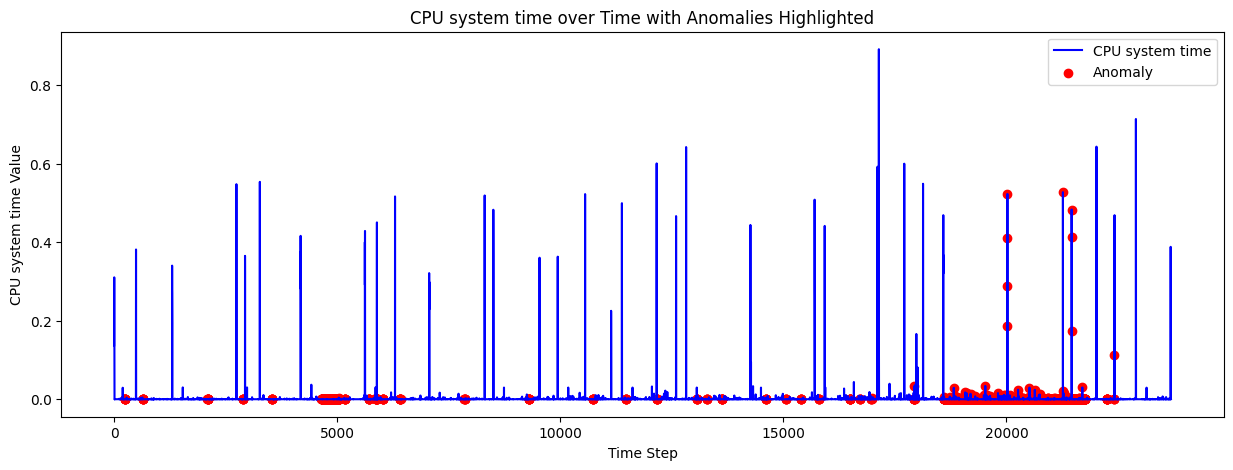

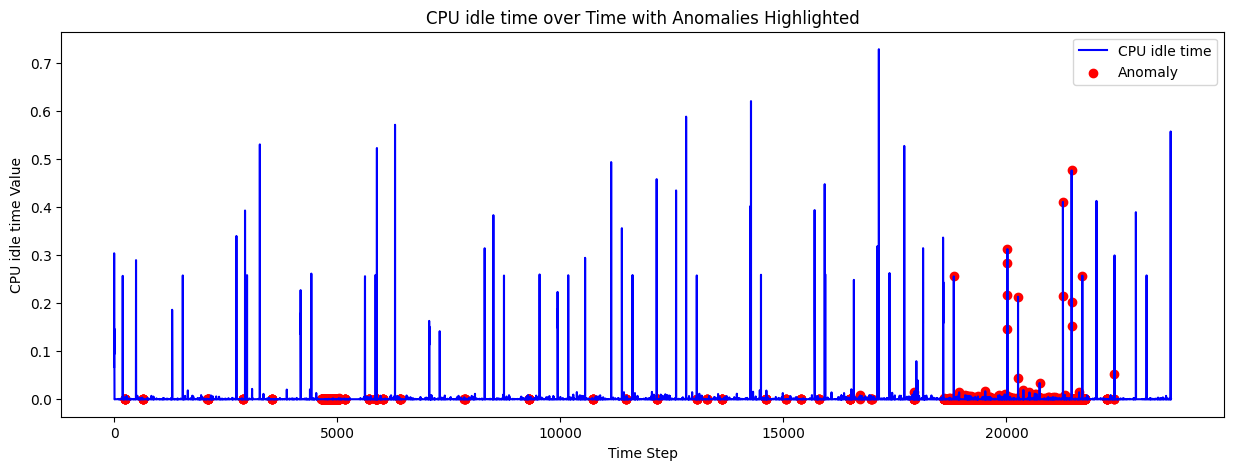

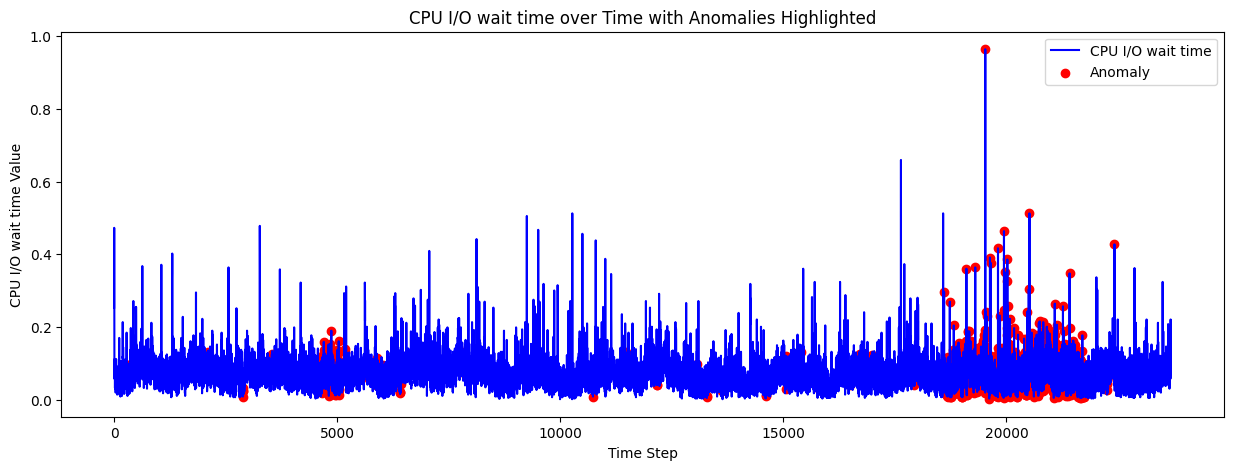

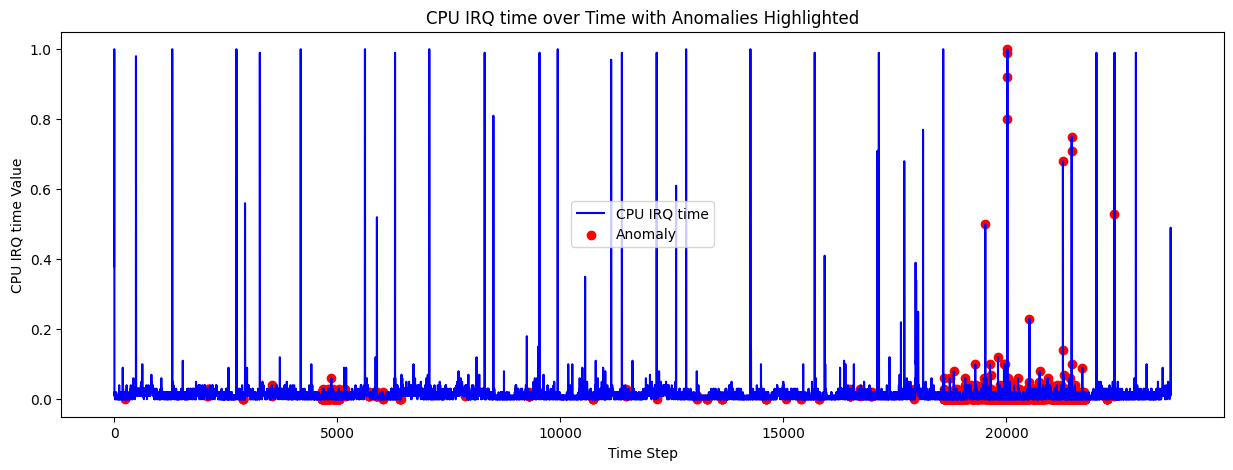

In [ ]:
import matplotlib.pyplot as plt

# Function to plot a given dimension with anomalies highlighted
def plot_dimension_with_anomalies(dimension_name):
    plt.figure(figsize=(15, 5))
    plt.plot(df[dimension_name], label=dimension_name, color='blue')

    # Highlighting anomalies
    anomalies = df[df['Anomaly'] == 1]
    plt.scatter(anomalies.index, anomalies[dimension_name], color='red', label='Anomaly')

    plt.title(f"{dimension_name} over Time with Anomalies Highlighted")
    plt.xlabel("Time Step")
    plt.ylabel(f"{dimension_name} Value")
    plt.legend()
    plt.show()

# Plotting the specified dimensions as an example
for feature in column_names[9:13]:  # Adjust the range as needed to select specific features
    plot_dimension_with_anomalies(feature)


In [ ]:
df.columns

Index(['CPU utilization rate', 'CPU utilization rate 2', 'Memory usage rate',
       'Memory usage rate 2', 'Disk read throughput', 'Disk write throughput',
       'Network receive throughput', 'Network send throughput',
       'CPU user time', 'CPU system time', 'CPU idle time',
       'CPU I/O wait time', 'CPU IRQ time', 'CPU soft IRQ time',
       'CPU steal time', 'Context switches', 'Interrupts', 'Load 1 minute',
       'Load 5 minutes', 'Load 15 minutes', 'Disk used space',
       'Disk free space', 'Disk total space', 'Disk read latency',
       'Disk write latency', 'Disk read IOPS', 'Disk write IOPS',
       'Network inbound packets', 'Network outbound packets',
       'Network inbound errors', 'Network outbound errors',
       'Network inbound drops', 'Network outbound drops',
       'Network connections established', 'Network connections listening',
       'Network connections time wait', 'Network connections close wait',
       'Network connections closed', 'Anomaly'],
    

In [ ]:
"""
#PCA 실험
X = df.dropna()
from sklearn.decomposition import PCA
pca = PCA(n_components=4) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns=['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

new_df = pd.DataFrame()
new_df['Dimension 1'] = df['Dimension 1']
new_df['Anomaly'] = df['Anomaly']
new_df = pd.concat([new_df, principalDf], axis=1)

new_df
"""

"\n#PCA 실험\nX = df.dropna()\nfrom sklearn.decomposition import PCA\npca = PCA(n_components=4) # 주성분을 몇개로 할지 결정\nprintcipalComponents = pca.fit_transform(X)\nprincipalDf = pd.DataFrame(data=printcipalComponents, columns=['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])\n\nnew_df = pd.DataFrame()\nnew_df['Dimension 1'] = df['Dimension 1']\nnew_df['Anomaly'] = df['Anomaly']\nnew_df = pd.concat([new_df, principalDf], axis=1)\n\nnew_df\n"

In [ ]:
'''!!!시간 수정!!!'''
past_history = 24
future_target = 6
STEP = 1
predict_col = 0

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index, target_size):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [ ]:

def preprocessing(data, past_history, future_target, STEP, predict_col, feature):

    TRAIN_SPLIT = int(len(data)* 0.8)
    #TRAIN_SPLIT = int(len(data)-len(df2))

    #피쳐
    features_considered = feature


    features = data[features_considered]
    #features.index = data['date']
    #features.plot(subplots=True)
    F_dataset = features.values
    print(np.shape(F_dataset))
    F_scaler.fit(F_dataset)
    F_dataset = F_scaler.transform(F_dataset)
    print(np.shape(F_dataset))
    F_dataset = F_dataset.reshape(-1, len(features_considered))
    print(np.shape(F_dataset))
    print(F_dataset)

    #타겟
    features_considered = ['CPU utilization rate']
    features = data[features_considered]
    T_dataset = features.values
    T_scaler.fit(T_dataset)
    T_dataset = T_scaler.transform(T_dataset)
    T_dataset = T_dataset.reshape(-1, 1)
    print(np.shape(T_dataset))
    print(T_dataset)

    #이상치
    anomal = ['Anomaly']
    features = data[anomal]
    anomal_dataset = features.values

    anomal_dataset = anomal_dataset.reshape(-1, 1)
    print(np.shape(T_dataset))
    print(T_dataset)

    dataset = np.concatenate((T_dataset, F_dataset), axis=1)
    print(dataset)
    x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, predict_col], 0, TRAIN_SPLIT, past_history, future_target, STEP)

    x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)
    x_val_anomal, y_val_anomal = multivariate_data(anomal_dataset, anomal_dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)
    return x_train_multi, y_train_multi, x_val_multi, y_val_multi, x_val_anomal, y_val_anomal


In [ ]:
F_scaler = MinMaxScaler()
T_scaler = MinMaxScaler()
'''!!!피쳐 수정!!!'''
feature_considered = ['CPU utilization rate 2', 'Memory usage rate', 'Memory usage rate 2',
    'Disk read throughput']
x_train_multi, y_train_multi, x_val_multi, y_val_multi, x_val_anomal, y_val_anomal = preprocessing(df, past_history, future_target, STEP, predict_col, feature_considered)

(23687, 4)
(23687, 4)
(23687, 4)
[[0.05415329 0.03914218 0.06944407 0.7600001 ]
 [0.50457385 0.23421764 0.21249921 0.7600001 ]
 [0.37614284 0.30303113 0.28472128 0.7600001 ]
 ...
 [0.08927958 0.11931767 0.24722125 0.88000005]
 [0.25283564 0.18560611 0.2958333  0.88000005]
 [0.13757746 0.16666743 0.28749929 0.88000005]]
(23687, 1)
[[0.31578902]
 [0.89473628]
 [0.86841982]
 ...
 [0.31578902]
 [0.36842195]
 [0.34210549]]
(23687, 1)
[[0.31578902]
 [0.89473628]
 [0.86841982]
 ...
 [0.31578902]
 [0.36842195]
 [0.34210549]]
[[0.31578902 0.05415329 0.03914218 0.06944407 0.7600001 ]
 [0.89473628 0.50457385 0.23421764 0.21249921 0.7600001 ]
 [0.86841982 0.37614284 0.30303113 0.28472128 0.7600001 ]
 ...
 [0.31578902 0.08927958 0.11931767 0.24722125 0.88000005]
 [0.36842195 0.25283564 0.18560611 0.2958333  0.88000005]
 [0.34210549 0.13757746 0.16666743 0.28749929 0.88000005]]


In [ ]:
x_val_anomal

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

In [ ]:
np.shape(x_train_multi)

(3155, 24, 5)

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 10
EPOCHS = 10
EVALUATION_INTERVAL = len(x_train_multi)//BATCH_SIZE
VALIDATION_STEPS = len(x_val_multi)//BATCH_SIZE # if you have validation data

In [ ]:
def create_time_steps(length):
  return range(-length, 0)

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)


  plt.plot(num_in, np.array(history[:, predict_col]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'g',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
from torch import nn, optim
import torch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
epochs = 50

validation = 0.1

In [ ]:
x_val_multi.shape

(785, 24, 5)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='mse', min_delta=0.0001, patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\
DATA_OUT_PATH = '/Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUT'
model_name = 'two_lstm'
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))


cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='mse', verbose=1, save_best_only=True, save_weights_only=True)

/Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm -- Folder create complete 



In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Attention
from keras.layers import concatenate

In [ ]:
adam = optimizers.Adam(lr = 0.001)

In [ ]:
from keras.layers import Input, Conv1D, Flatten, LSTM, Dense, concatenate, Dropout, Attention

input1 = Input(shape=x_train_multi.shape[-2:])
dense1 = Conv1D(filters=16, kernel_size=1, activation='relu')(input1)
dense1_2 = Conv1D(filters=32, kernel_size=1, activation='relu')(dense1)
dense1_3 = Conv1D(filters=64, kernel_size=1, activation='relu')(dense1_2)
dense1_4 = Flatten()(dense1_3)

input2 = Input(shape=x_train_multi.shape[-2:])
dense2 = LSTM(16, return_sequences=True)(input2)
dense2_2 = LSTM(32, return_sequences=True)(dense2)
dense2_3 = LSTM(64, return_sequences=True)(dense2_2)

# Add self-attention
attention = Attention()([dense2_3, dense2_3])

# Flatten the output of the attention layer
attention_flat = Flatten()(attention)

# Merge the two branches
merge1 = concatenate([dense1_4, attention_flat])

# Continue with the rest of the model
model2 = Dense(64)(merge1)
model3 = Dense(32)(model2)
output = Dense(future_target)(model3)

In [ ]:
model = Model(inputs = [input1, input2], outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 24, 5)]              0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 24, 5)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 24, 16)               1408      ['input_2[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 24, 16)               96        ['input_1[0][0]']             
                                                                                              

In [ ]:
model.compile(optimizer=adam, loss='mse', metrics=['mse'])

model_history=model.fit([x_train_multi, x_train_multi], y_train_multi, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          #validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS,
                                          batch_size = BATCH_SIZE, callbacks=[earlystop_callback, cp_callback], validation_data=([x_val_multi, x_val_multi], y_val_multi))


Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050
Epoch 1: mse improved from inf to 0.00498, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
98/98 [==============================] - 12s 22ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026
Epoch 2: mse improved from 0.00498 to 0.00256, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
98/98 [==============================] - 1s 11ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/20
95/98 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 0.0023
Epoch 3: mse improved from 0.00256 to 0.00232, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
98/98 [==============================] - 1s 11ms/step - loss: 0.

In [ ]:
mse = model.evaluate([x_val_multi, x_val_multi], y_val_multi, batch_size = 1)

785/785 [==============================] - 4s 5ms/step - loss: 0.0021 - mse: 0.0021


In [ ]:
y_predict = model.predict([x_val_multi[0:1000], x_val_multi[0:1000]])
#for i in tqdm(range(len(y_predict))):
#    print(y_val_multi[i], y_predict[i])

25/25 [==============================] - 1s 9ms/step


In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
from sklearn.metrics import r2_score
def RMSE(real, pred):
    return np.sqrt((1/len(real))* np.sum((real-pred)**2))

In [ ]:
answer_list = []
predict_list = []
anomal_list = []
for i in range(len(x_val_multi)):
    x = x_val_multi[i].reshape((-1, past_history, len(feature_considered)+1))
    answer = y_val_multi[i]
    anomal = y_val_anomal[i]
    predict = model.predict([x, x])[0]
    answer_list.append(answer)
    anomal_list.append(anomal)
    predict_list.append(predict)

1/1 [==============================] - 0s 21ms/step


In [ ]:
answer = np.reshape(answer_list, (-1, 1))
predict = np.reshape(predict_list, (-1, 1))
anomal = np.reshape(anomal_list, (-1, 1))



In [ ]:
np.shape(anomal_list)

(785, 6)

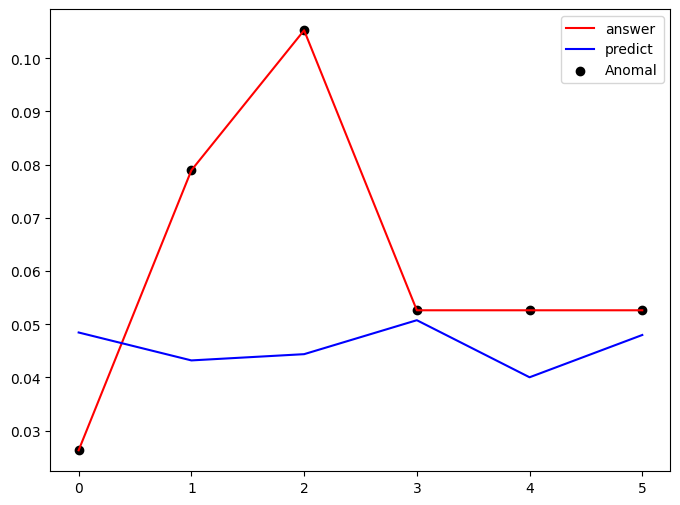

In [ ]:
t = 4
plt.plot(answer_list[t], color = 'r', label = 'answer')
plt.plot(predict_list[t], color = 'b', label = 'predict')
anomal_event = anomal_list[t]
indices_with_value_one = [index for index, value in enumerate(anomal_event) if np.any(value == 1)]
plt.scatter(indices_with_value_one, [answer_list[t][i] for i in indices_with_value_one], color='k', label='Anomal', marker='o')

plt.legend()
plt.show()

In [ ]:
import numpy as np



# 값이 1인 인덱스 저장
indices_with_value_one = [index for index, value in enumerate(anomal) if np.any(value == 1)]

# 결과 출력
print("값이 1인 인덱스:", indices_with_value_one)


값이 1인 인덱스: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

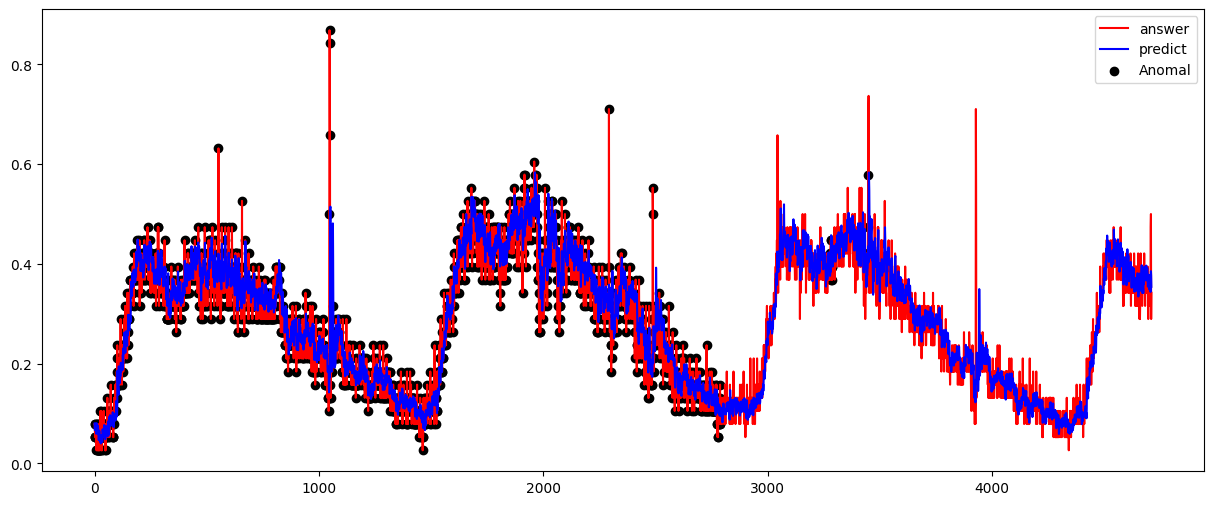

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(answer, color = 'r', label = 'answer')
plt.plot(predict, color = 'b', label = 'predict')
plt.scatter(indices_with_value_one, [answer[i] for i in indices_with_value_one], color='k', label='Anomal', marker='o')  # 이상치 산점도

plt.legend()
plt.show()

In [ ]:
anomal_predict = [predict[i] for i, value in enumerate(anomal) if value == 1]
anomal_answer = [answer[i] for i, value in enumerate(anomal) if value == 1]

print(anomal_predict)
print(anomal_answer)

[array([0.08003785], dtype=float32), array([0.06686382], dtype=float32), array([0.06672308], dtype=float32), array([0.07960468], dtype=float32), array([0.0667934], dtype=float32), array([0.07576817], dtype=float32), array([0.07425874], dtype=float32), array([0.05959275], dtype=float32), array([0.06121116], dtype=float32), array([0.08067285], dtype=float32), array([0.06556726], dtype=float32), array([0.07345116], dtype=float32), array([0.06128468], dtype=float32), array([0.06013465], dtype=float32), array([0.06207882], dtype=float32), array([0.0759243], dtype=float32), array([0.06849352], dtype=float32), array([0.06118991], dtype=float32), array([0.04881982], dtype=float32), array([0.04661256], dtype=float32), array([0.0514503], dtype=float32), array([0.06552059], dtype=float32), array([0.05760225], dtype=float32), array([0.05216232], dtype=float32), array([0.04845607], dtype=float32), array([0.04320884], dtype=float32), array([0.0443824], dtype=float32), array([0.05076577], dtype=float

In [ ]:
#정상
import numpy as np


# 각 요소별로 차이 계산
diffs = [abs(pred - ans) for pred, ans in zip(predict, answer)]

# 평균 계산
mean_diff = np.mean(diffs)

# 평균을 answer의 각 요소에 대한 평균 값으로 나누고 100을 곱하여 백분율로 표현
mean_percentage_diff = (mean_diff / np.mean(answer)) * 100
a = answer
b = predict
from sklearn.metrics import mean_absolute_percentage_error
#print(mae(a, b).numpy())
print("전체 구간 mse :", mse(a, b).numpy())
#print(r2_score(a, b))
#print(RMSE(a, b))
#print(mean_absolute_percentage_error(answer, predict))
print("전체 구간 평균 백분율:", mean_percentage_diff)


#이상
import numpy as np


# 각 요소별로 차이 계산
diffs = [abs(pred - ans) for pred, ans in zip(anomal_predict, anomal_answer)]

# 평균 계산
mean_diff = np.mean(diffs)

# 평균을 answer의 각 요소에 대한 평균 값으로 나누고 100을 곱하여 백분율로 표현
mean_percentage_diff = (mean_diff / np.mean(answer)) * 100
a = anomal_answer
b = anomal_predict
from sklearn.metrics import mean_absolute_percentage_error
#print(mae(a, b).numpy())
print("이상 구간 mse :", mse(a, b).numpy())
#print(r2_score(a, b))
#print(mean_absolute_percentage_error(answer, predict))
print("이상 구간 평균 백분율:", mean_percentage_diff)


전체 구간 mse : 0.0021389346
전체 구간 평균 백분율: 11.516656530983576
이상 구간 mse : 0.0023762912
이상 구간 평균 백분율: 11.916025402568048


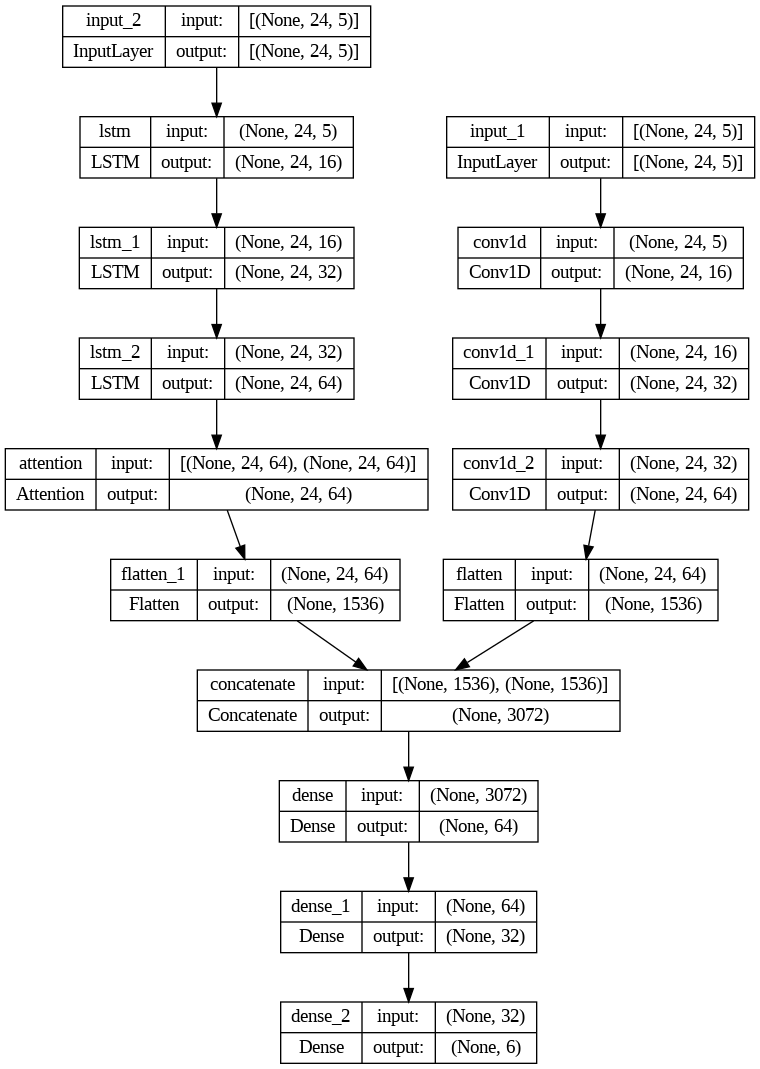

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the model plot in Colab
from IPython.display import Image
Image(filename='model_plot.png')